In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
import datetime
from keras.layers import  Dense, GlobalAveragePooling2D

In [ ]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [ ]:

img_height , img_weight = (244,244)
batch_size = 32
train_data_dir = r"/content/gdrive/MyDrive/m244/train"
#test_data_dir = r"/content/gdrive/MyDrive/m244/test"
test_data_dir = r"/content/gdrive/MyDrive/final test/test"

valid_data_dir = r"/content/gdrive/MyDrive/m244/valid"

class_names=os.listdir(train_data_dir)
class_names_test=os.listdir(test_data_dir)
class_names_val=os.listdir(valid_data_dir)

In [ ]:
print(class_names)
print(class_names_test)
print(class_names_val)

['Chromophobe', 'Oncocytoma']
['Oncocytoma', 'Chromophobe']
['Oncocytoma', 'Chromophobe']


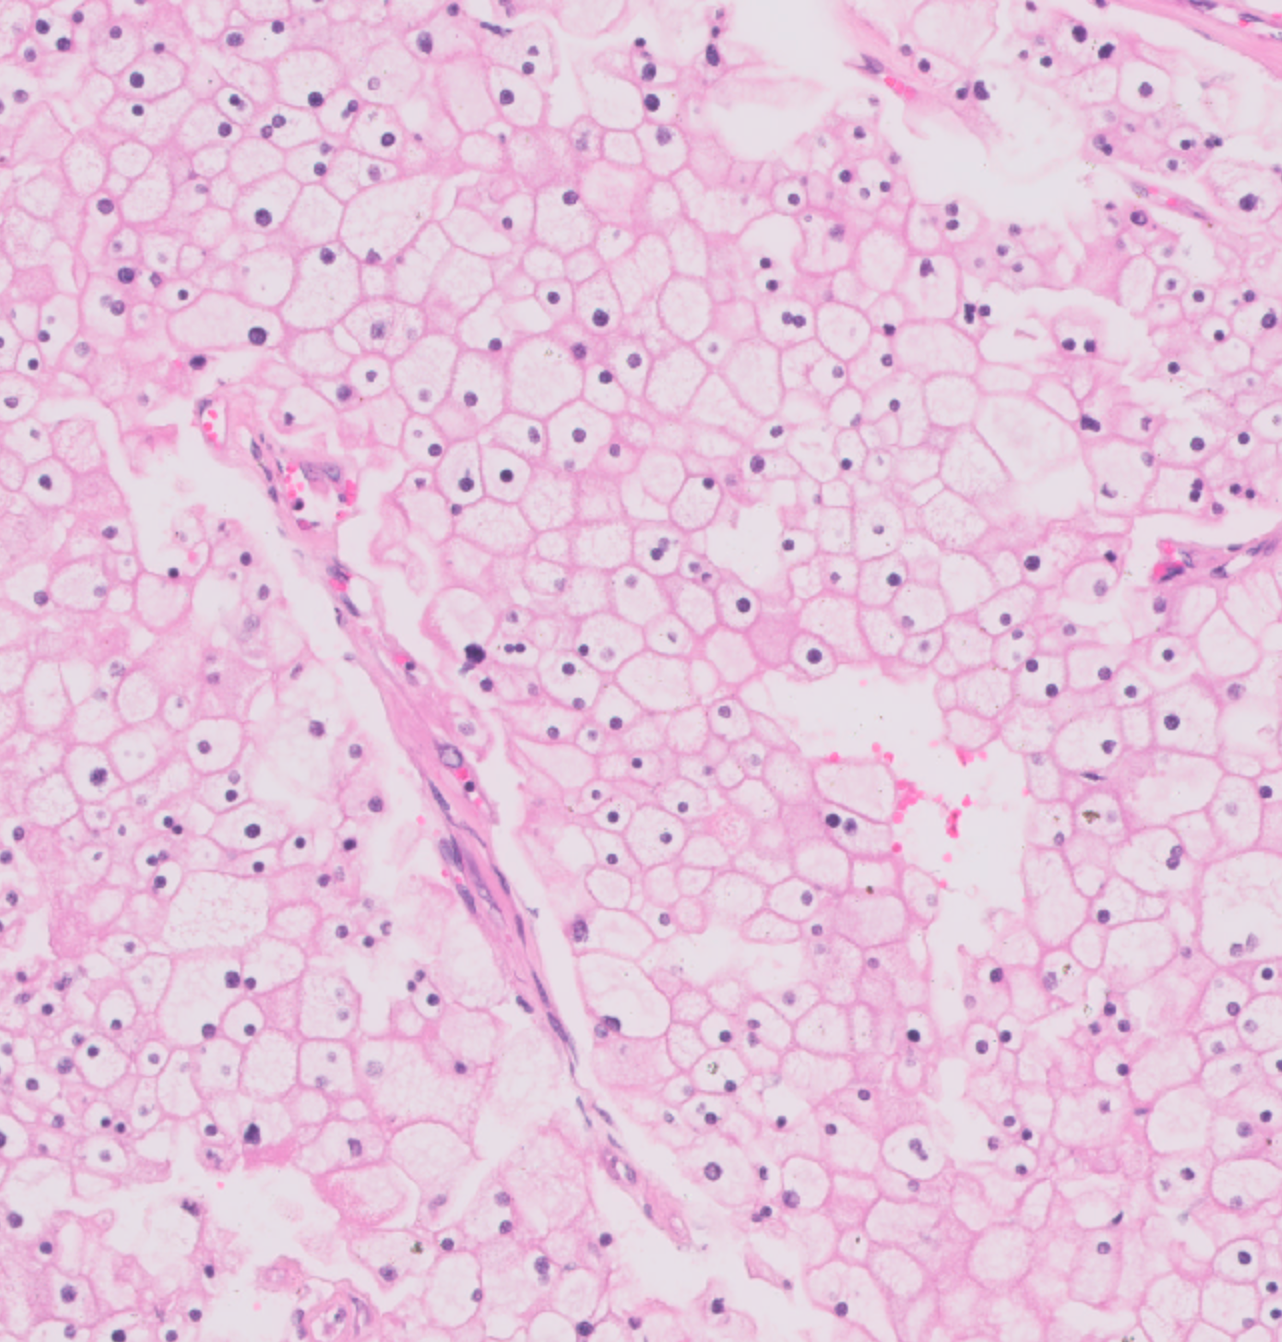

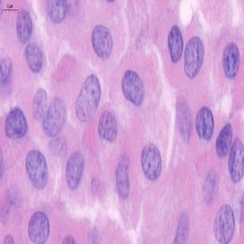

In [ ]:
#Sample datasets images
image_chromophobe=cv2.imread("/content/gdrive/MyDrive/final test/test/Chromophobe/Screen Shot 2022-08-30 at 10.15.53 PM222.png")
cv2_imshow(image_chromophobe)
image_oncocytoma=cv2.imread("/content/gdrive/MyDrive/m244/test/Oncocytoma/2021-02-17T23-00-42-R3-S1_167-0x-resized_jpg.rf.f4b2d52e3aad835abffaede96c89ba00 resized.jpg")
cv2_imshow(image_oncocytoma)

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/gdrive/MyDrive/m244/train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='categorical')
test_generator = test_datagen.flow_from_directory("/content/gdrive/MyDrive/final test/test",target_size=(224,224),batch_size=32,shuffle=False,class_mode='categorical')
valid_generator = test_datagen.flow_from_directory("/content/gdrive/MyDrive/m244/valid",target_size=(224,224),batch_size=32,shuffle=False,class_mode='categorical')
x,y = test_generator.next()
x.shape

Found 948 images belonging to 2 classes.
Found 68 images belonging to 2 classes.
Found 274 images belonging to 2 classes.


(32, 224, 224, 3)

In [ ]:
from tensorflow.keras import optimizers
from tensorflow import keras


logdir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
base_model =ResNet50(include_top = False , weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256 , activation='relu')(x)
predictions = Dense(train_generator.num_classes , activation = 'softmax')(x)
model = Model(inputs=base_model.input , outputs = predictions)

for layer in base_model.layers:
    layer.trainable = True
#sgd = optimizers.SGD(lr=0.01 ,decay = 1e-6,momentum = 0.9, nesterov=True)

es=EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5,restore_best_weights=True,)
mc = ModelCheckpoint('/content/gdrive/My Drive/models/bestresnet50.h5', monitor='val_accuracy')
model.compile(optimizer='Adam' , loss = 'categorical_crossentropy' , metrics=['accuracy'])
training_history=model.fit_generator(train_generator,validation_data=test_generator,epochs=30,verbose=1,callbacks=[tensorboard_callback, mc, es])


model.save('/content/gdrive/My Drive/models/bestresnet50.h5')

<ipython-input-30-0c8679fa83e7>:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  training_history=model.fit_generator(train_generator,validation_data=test_generator,epochs=30,verbose=1,callbacks=[tensorboard_callback, mc, es])


Epoch 1/30
30/30 [==============================] - 28s 778ms/step - loss: 0.3304 - accuracy: 0.9008 - val_loss: 2949.0115 - val_accuracy: 0.4706
Epoch 2/30
30/30 [==============================] - 21s 705ms/step - loss: 0.2351 - accuracy: 0.9293 - val_loss: 55617.6992 - val_accuracy: 0.4706
Epoch 3/30
30/30 [==============================] - 22s 720ms/step - loss: 0.1010 - accuracy: 0.9631 - val_loss: 405.1421 - val_accuracy: 0.5588
Epoch 4/30
30/30 [==============================] - 21s 715ms/step - loss: 0.1177 - accuracy: 0.9494 - val_loss: 150.7788 - val_accuracy: 0.4706
Epoch 5/30
30/30 [==============================] - 21s 701ms/step - loss: 0.0876 - accuracy: 0.9684 - val_loss: 13.1461 - val_accuracy: 0.4706
Epoch 6/30
30/30 [==============================] - 21s 695ms/step - loss: 0.0862 - accuracy: 0.9715 - val_loss: 110.0320 - val_accuracy: 0.4706
Epoch 7/30
30/30 [==============================] - 21s 684ms/step - loss: 0.1408 - accuracy: 0.9557 - val_loss: 2.4975 - val_ac

In [ ]:
model.load_weights('/content/gdrive/My Drive/models/bestresnet50.h5')


In [ ]:
model.evaluate_generator(test_generator)


<ipython-input-32-faa0e9406f88>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator)


[0.7876728773117065, 0.8823529481887817]

In [ ]:
Y_pred = model.predict_generator(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(valid_generator.classes, y_pred))
print('Classification Report')
target_names = ['Oncocytoma', 'Chromophobe',]
print(classification_report(valid_generator.classes, y_pred, target_names=target_names))


<ipython-input-33-0d5ad2abe715>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(valid_generator)


Confusion Matrix
[[121   0]
 [  6 147]]
Classification Report
              precision    recall  f1-score   support

  Oncocytoma       0.95      1.00      0.98       121
 Chromophobe       1.00      0.96      0.98       153

    accuracy                           0.98       274
   macro avg       0.98      0.98      0.98       274
weighted avg       0.98      0.98      0.98       274



In [ ]:
Y_pred = model.predict_generator(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Oncocytoma', 'Chromophobe',]
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

<ipython-input-34-2d8241158144>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(test_generator)


Confusion Matrix
[[35  1]
 [ 7 25]]
Classification Report
              precision    recall  f1-score   support

  Oncocytoma       0.83      0.97      0.90        36
 Chromophobe       0.96      0.78      0.86        32

    accuracy                           0.88        68
   macro avg       0.90      0.88      0.88        68
weighted avg       0.89      0.88      0.88        68



In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "ResNet50" \
  --description "Training results from https://colab.sandbox.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb" \
  --one_shot


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.8/dist-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.8/dist-packages/tensorboard/program.py", line 276, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/pyt

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/WPySWo78RGCOH2NbxKzXrg/
	Name                 ResNet50
	Description          Training results from https://colab.sandbox.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb
	Id                   WPySWo78RGCOH2NbxKzXrg
	Created              2022-11-24 09:34:05 (7 seconds ago)
	Updated              2022-11-24 09:34:07 (5 seconds ago)
	Runs                 2
	Tags                 5
	Scalars              72
	Tensor bytes         0
	Binary object bytes  393619
https://tensorboard.dev/experiment/Awd0CWllSOeZOW5serGYXw/
	Name                 vgg19
	Description          Training results from https://colab.sandbox.google.com/github/tensorflow/tensorboard/blob/master/docs/tbdev_getting_started.ipynb
	Id                   Awd0CWllSOeZOW5serGYXw
	Created              2022-11-24 08:19:20 (1 hour ago)
	Updated              2022-11-24 08:19:26 (1 hour ago)
	Runs                 12
	Tags                 5
	Scalars              918
	T